# Settings

In [1]:
import sys
import os

os.chdir('..')
os.getcwd()

'C:\\Users\\ruben\\Documents\\GitHub\\ANLP-Project'

# Imports

In [2]:
! pip install editdistance
! pip install num2words

In [3]:
from scripts.model import device, CharBiLSTM
from scripts.data import create_data_loader, load_data
from scripts.preprocessing import get_typoglycemia_modified_data, sentence_tokennizer, tokenize_dataframe, get_max_length
from scripts.baseline import get_base_line_score

from torch import nn, optim
import torch

from sklearn.model_selection import train_test_split

import editdistance
#from tqdm import tqdm
# from tqdm.notebook import tqdm
from tqdm.autonotebook import trange, tqdm
import random 

from sklearn.metrics import f1_score, accuracy_score
import numpy as np



import pandas as pd
import matplotlib.pyplot as plt
random.seed(42)
torch.manual_seed(42);

device

C:\Users\ruben\AppData\Local\Temp\ipykernel_9716\2117565946.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


device(type='cuda')

# Data

In [4]:
df = load_data(file_path = "data/processed/sscorpus.csv")

In [5]:
df.head(3)

,Hard,Easy,Similarity,Easy_Typo,Hard_Typo
0,on the Dover Air Force Base .,It ends near the Dover Air Force Base and DE o...,0.7,It edns naer the Dover Air Frcoe Bsae and DE o...,on the Dveor Air Froce Bsae .
1,in games including `` Super Smash Bros. '' and...,He has been in a number of video games includi...,0.7,He has been in a nubemr of vdeio games iinudcn...,in gmeas iiudcnlng `` Suepr Smash Bsor. '' and...
2,"`` Usucha '' , or thin tea , is prepared with ...","`` Usucha '' , or thin tea , is prepared with ...",0.7,"`` Uhusca '' , or tihn tea , is ppareerd with ...","`` Usucha '' , or thin tea , is prpraeed wtih ..."


## Splitting data into train, val, test

In [6]:
dev, test = train_test_split(df, test_size=0.2)
train, validation = train_test_split(dev, test_size=0.2)

## Baseline dev

In [7]:
get_base_line_score(train = train, test = test, type = 'Easy')

The base line has a mean editdistance of 0.259 pr. sentence, and 0.264 pr. word


In [8]:
get_base_line_score(train = train, test = test, type = 'Hard')

The base line has a mean editdistance of 0.296 pr. sentence, and 0.29 pr. word


## Getting dataloaders

In [9]:
complexity_level = "Hard"

In [10]:
train = tokenize_dataframe(train, complexity_level)
validation = tokenize_dataframe(validation, complexity_level)
test = tokenize_dataframe(test, complexity_level)

In [11]:
combined_text = ' '.join(train["Hard_Typo"])
unique_characters = set(combined_text)
vocabulary_size = len(unique_characters)
vocabulary_size

27

Five-number summary: Min: 9, Q1: 89.0, Median: 130.0, Q3: 182.0, Max: 1319
Mean: 143.99036151935837, Std Dev: 76.95859269836403


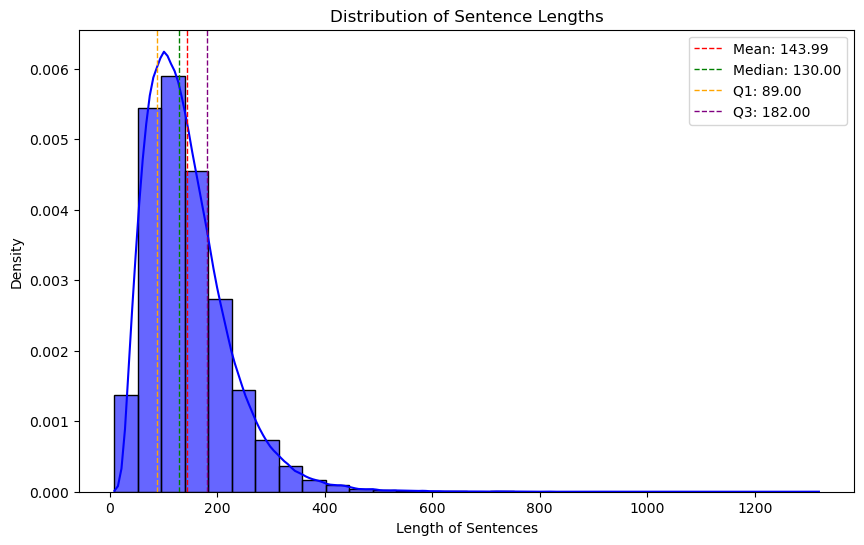

Five-number summary: Min: 15, Q1: 89.0, Median: 130.0, Q3: 183.0, Max: 1020
Mean: 144.59693441354884, Std Dev: 77.69253288329301


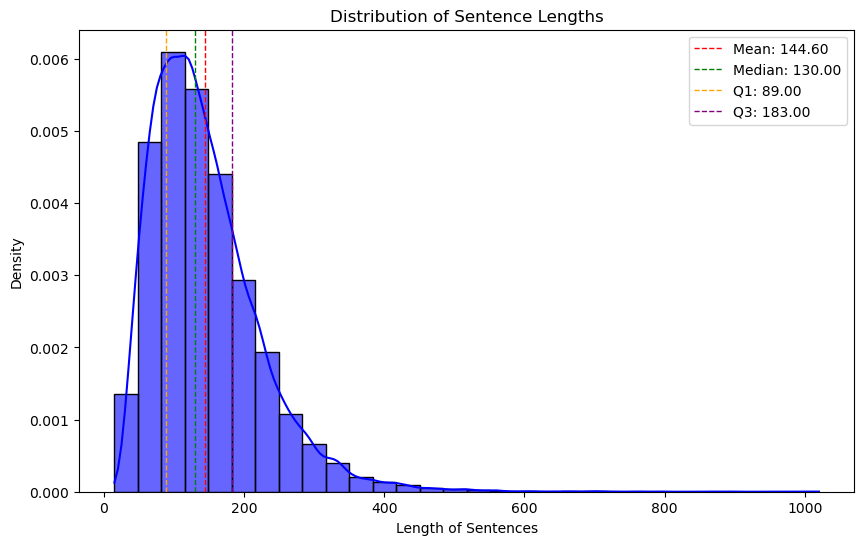

Five-number summary: Min: 19, Q1: 89.0, Median: 130.0, Q3: 182.0, Max: 1052
Mean: 143.85114317352787, Std Dev: 76.5395632313453


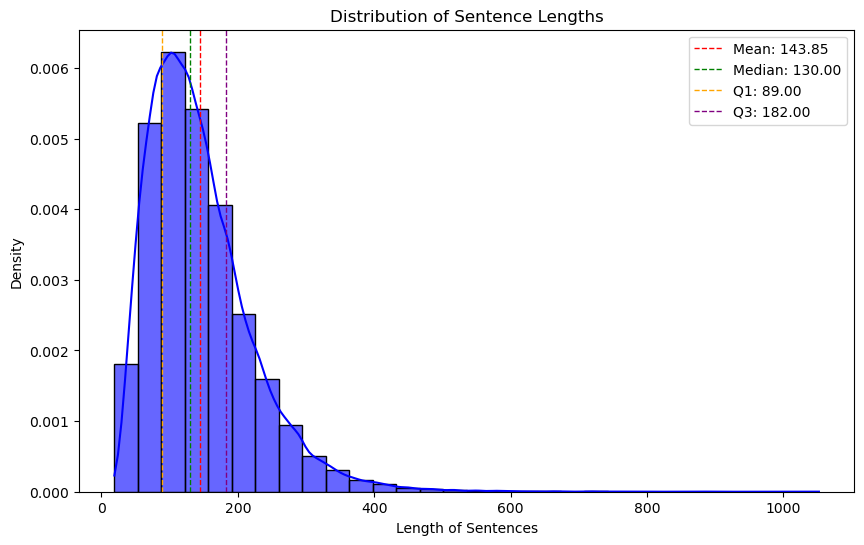

In [12]:
max_length_train = get_max_length(train, complexity_level)
max_length_validation = get_max_length(validation, complexity_level)
max_length_test = get_max_length(test, complexity_level)

In [13]:
max_length = max([max_length_train, max_length_validation, max_length_test])
max_length=300
max_length


300

In [14]:
all_sentences = pd.concat([df[complexity_level], df[complexity_level + "_Typo"]])
lengths = all_sentences.str.len()
lengths

0          29
1          50
2         396
3          86
4         162
         ... 
307033     76
307034     94
307035    236
307036     63
307037     85
Length: 614076, dtype: int64

In [15]:
batch_size = 2**8
# batch_size = 2

In [16]:
train_loader = create_data_loader(train, complexity=complexity_level, max_length=max_length, batch_size=batch_size) # TODO 
validation_loader = create_data_loader(validation, complexity=complexity_level, max_length=max_length, batch_size=batch_size) # TODO 
test_loader = create_data_loader(test, complexity=complexity_level, max_length=max_length, batch_size=batch_size) # TODO 

In [17]:
for sample in train_loader:
    X, y = sample
    print(X.shape, y.shape)
    print(np.unique(y.cpu(), return_counts=True))
    break

torch.Size([64, 300]) torch.Size([64, 300])
(array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64), array([10386,   629,    86,   197,   352,   909,   164,   131,   343,
         556,    13,    36,   268,   175,   686,   565,   122,     5,
         507,   437,   642,   205,    98,   135,    25,   124,  1404],
      dtype=int64))


# Model  (Not finished just a template)

In [18]:
input_size = vocabulary_size 
input_size = 1  # Uses the raw index in alphabet as input
hidden_size = 2**5 # Maps to hidden size
output_size = vocabulary_size +  1  # Outputs probabilities for each character in vocabulary + padding
num_layers = 1   

model = CharBiLSTM(input_size, hidden_size, output_size, num_layers, max_length, batch_size).to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=-1).to(device) # Padding is value -1, therefore we want to ignore it in our loss function
optimizer = optim.Adam(model.parameters(), lr=0.02, amsgrad=True)

epochs = 200

# Training

In [19]:
val_loss_dc = {}
train_loss_dc = {}

for epoch in tqdm(range(epochs), position=0):
    model.train()
    epoch_loss = 0.0    
    for batch in tqdm(train_loader, position=1, leave=False):
        typo_batch, sentence_batch = batch  
        
        sentence_batch = sentence_batch.view(-1)
        typo_batch = typo_batch.reshape(-1, max_length, 1)

        y = model.forward(typo_batch, train=False)  
        loss = loss_function(y, sentence_batch)  
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    epoch_loss_avg = epoch_loss / len(train_loader)
    train_loss_dc[epoch] = epoch_loss_avg

    model.eval()
    val_loss = 0.0
    with torch.no_grad():  
        for val_batch in tqdm(validation_loader, position=2, leave=False):
            typo_val_batch, sentence_val_batch = val_batch
            
            sentence_val_batch = sentence_val_batch.view(-1)
            typo_val_batch = typo_val_batch.reshape(-1, max_length, 1)
            
            val_y = model.forward(typo_val_batch, train=False)
            
            val_loss_batch = loss_function(val_y, sentence_val_batch)
            val_loss += val_loss_batch.item()
                
    val_loss_avg = val_loss / len(validation_loader)
    val_loss_dc[epoch] = val_loss_avg
    
    print(f"Epoch {epoch + 1}/{epochs} Train Loss: {epoch_loss_avg:.8f} Val Loss: {val_loss_avg:.8f}")

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 1/200 Train Loss: 3.02936707 Val Loss: 3.01353024


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 2/200 Train Loss: 3.01078981 Val Loss: 3.00872577


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 3/200 Train Loss: 3.00825831 Val Loss: 3.00758569


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 4/200 Train Loss: 3.00683736 Val Loss: 3.00572512


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 5/200 Train Loss: 2.99611777 Val Loss: 2.99383133


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 6/200 Train Loss: 2.99397213 Val Loss: 2.99366851


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 7/200 Train Loss: 2.99418114 Val Loss: 2.99465433


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 8/200 Train Loss: 2.99426869 Val Loss: 2.99449321


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 9/200 Train Loss: 2.99331833 Val Loss: 2.99340572


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 10/200 Train Loss: 2.99302397 Val Loss: 2.99501545


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 11/200 Train Loss: 2.99390828 Val Loss: 2.99464215


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 12/200 Train Loss: 2.99277705 Val Loss: 2.99230057


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 13/200 Train Loss: 2.99245985 Val Loss: 2.99223289


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 14/200 Train Loss: 2.99241754 Val Loss: 2.99196870


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 15/200 Train Loss: 2.99218889 Val Loss: 2.99152891


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 16/200 Train Loss: 2.99198473 Val Loss: 2.99163236


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 17/200 Train Loss: 2.99396641 Val Loss: 2.99474274


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 18/200 Train Loss: 2.99393545 Val Loss: 2.99317101


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 19/200 Train Loss: 2.99354922 Val Loss: 2.99363522


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 20/200 Train Loss: 2.99337414 Val Loss: 2.99324218


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 21/200 Train Loss: 2.99324674 Val Loss: 2.99258521


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 22/200 Train Loss: 2.99296940 Val Loss: 2.99317180


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 23/200 Train Loss: 2.99274912 Val Loss: 2.99251930


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 24/200 Train Loss: 2.99286177 Val Loss: 2.99276783


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 25/200 Train Loss: 2.99286706 Val Loss: 2.99227096


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 26/200 Train Loss: 2.99267885 Val Loss: 2.99216009


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 27/200 Train Loss: 2.99263382 Val Loss: 2.99237358


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 28/200 Train Loss: 2.99267849 Val Loss: 2.99234063


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 29/200 Train Loss: 2.99273100 Val Loss: 2.99224020


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 30/200 Train Loss: 2.99265092 Val Loss: 2.99255361


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 31/200 Train Loss: 2.99263710 Val Loss: 2.99231612


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 32/200 Train Loss: 2.99386621 Val Loss: 2.99333646


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 33/200 Train Loss: 2.99514617 Val Loss: 2.99416330


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 34/200 Train Loss: 2.99440989 Val Loss: 2.99381808


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 35/200 Train Loss: 2.99389083 Val Loss: 2.99369894


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 36/200 Train Loss: 2.99377472 Val Loss: 2.99351693


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 37/200 Train Loss: 2.99362233 Val Loss: 2.99371662


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 38/200 Train Loss: 2.99350272 Val Loss: 2.99366593


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 39/200 Train Loss: 2.99547233 Val Loss: 2.99881312


  0%|          | 0/3071 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

Epoch 40/200 Train Loss: 2.99782919 Val Loss: 2.99675747


  0%|          | 0/3071 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(train_loss_dc.keys(), train_loss_dc.values(), label="Train Loss")
plt.plot(val_loss_dc.keys(), val_loss_dc.values(), label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

# Evaluation

In [ ]:
def index_to_char(index):
    index = int(index)
    if 1 <= index <= 25:
        return chr(index + ord('a') - 1)
    elif index == 26:
        return ' '
    else:
        return "_"  # for all other values, return None

In [ ]:
import csv

def get_metrics(loader, model, loader_str, output_file="output.csv", sample_size=10):
    preds = []
    labels = []
    inputs = []  # To store input sequences
    
    model.eval()
    loss = 0.0
    csv_data = [["Input Word", "Label Word", "Predicted Word"]]  # CSV header
    sentence_label = []
    sentence_pred = []
    sentence_input = []  # To store input words
    word_label = []
    word_pred = []
    word_input = []

    with torch.no_grad():
        for batch in tqdm(loader, position=3, leave=False):
            typo_batch, sentence_batch = batch  # typo_batch is the input, sentence_batch is the target sequence

            # Reshape inputs for model and get predictions
            sentence_batch = sentence_batch.view(-1)
            typo_batch = typo_batch.reshape(-1, max_length, 1)
            y = model.forward(typo_batch, train=False)  # y should be shape (batch_size, seq_len, vocab_size)
            
            # Calculate and accumulate loss
            loss_batch = loss_function(y, sentence_batch)
            loss += loss_batch.item()
            
            # Get predictions, labels, and inputs in a flattened form
            batch_preds = torch.argmax(y, dim=1).cpu().numpy().reshape(-1)
            batch_labels = sentence_batch.cpu().numpy().reshape(-1)
            batch_inputs = typo_batch.cpu().numpy().reshape(-1)
            
            # Append these results for later accuracy and F1 calculations
            preds.extend(batch_preds)
            labels.extend(batch_labels)
            inputs.extend(batch_inputs)
            
            # Process each element in the batch
            for label_idx in range(len(batch_preds)):
                label_char = index_to_char(batch_labels[label_idx])
                pred_char = index_to_char(batch_preds[label_idx])
                input_char = index_to_char(batch_inputs[label_idx])
                
                # Ignore padding characters
                if label_char != "_":
                    word_label.append(label_char)
                if pred_char != "_":
                    word_pred.append(pred_char)
                if input_char != "_":
                    word_input.append(input_char)
                
                # If end of a word (detected by space), append word to csv_data
                if label_char == " ":
                    # Join and append the completed word to csv data
                    csv_data.append(["".join(word_input), "".join(word_label), "".join(word_pred)])
                    # Clear the lists for the next word
                    word_label = []
                    word_pred = []
                    word_input = []
                
    # Write data to CSV file
    with open(output_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Display a subset of rows in the old format for console output
    print(f"\nDisplaying the first {sample_size} rows from the output file:\n")
    print("Input Word      | Label Word      | Predicted Word")
    print("-" * 50)
    for row in csv_data[1:sample_size + 1]:  # Skip header row, take only `sample_size` rows
        print(f"{row[0]:<15} | {row[1]:<15} | {row[2]}")
    
    # Compute and display metrics
    loss_avg = loss / len(loader)
    print(f"\n{loader_str} Loss: {loss_avg:.4f}")
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    print(f"\n{loader_str} Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


In [ ]:
n_print = 50

In [ ]:
get_metrics(train_loader, model, "train", "train_predictions.csv", n_print)

In [ ]:
get_metrics(validation_loader, model, "validation", "validation_predictions.csv", n_print)

In [ ]:
get_metrics(test_loader, model, "test", "test_predictions.csv", n_print)